# Classification de déchets par CNN
Ce notebook guide pas à pas :

1. Chargement et préparation des images 
2. Définition d'un modèle CNN
3. Entraînement et évaluation
4. Sauvegarde du modèle

In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras import layers, models


## 1. Chargement et préparation des données
On part d'un dossier racine où chaque sous-dossier est une catégorie, contenant `default` et `real world`.

In [2]:
def load_datasets(root_dir,
                  img_size=(224, 224),
                  batch_size=32,
                  validation_split=0.2,
                  seed=123):
    # Liste des classes
    class_names = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ])

    # Récupération des chemins et labels
    image_paths, labels = [], []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for sub in ['default', 'real world']:
            subdir = os.path.join(class_dir, sub)
            if not os.path.isdir(subdir):
                continue
            for fname in os.listdir(subdir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(subdir, fname))
                    labels.append(idx)

    # Shuffle et split
    data = list(zip(image_paths, labels))
    random.seed(seed)
    random.shuffle(data)
    paths, lbls = zip(*data)
    split = int(len(paths)*(1-validation_split))
    train_paths, val_paths = paths[:split], paths[split:]
    train_lbls, val_lbls = lbls[:split], lbls[split:]

    # Préprocessing
    def preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img.set_shape([None, None, 3])            # fixe le rang pour resize
        img = tf.image.resize(img, img_size)
        img = img / 255.0
        return img, label


    train_ds = (tf.data.Dataset.from_tensor_slices((list(train_paths), list(train_lbls)))
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(1000)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

    val_ds = (tf.data.Dataset.from_tensor_slices((list(val_paths), list(val_lbls)))
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE))

    print("Classes détectées :", class_names)
    return train_ds, val_ds, class_names

## 2. Définition du modèle CNN

In [ ]:
# 3) Model builder with SeparableConv2D + BatchNorm + L2
def build_model(input_shape=(224,224,3), num_classes=2, l2=1e-4):
    return models.Sequential([
        layers.InputLayer(input_shape=input_shape),

        # Block 1
        layers.SeparableConv2D(32, 3, padding='same', use_bias=False,
                               kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),

        # Block 2
        layers.SeparableConv2D(64, 3, padding='same', use_bias=False,
                               kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),

        # Block 3
        layers.SeparableConv2D(128, 3, padding='same', use_bias=False,
                               kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),

        # Head
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

# 4) Custom LR schedule: warm-up + cosine decay
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, total_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)

        def warmup():
            return self.initial_lr * (step / warmup_steps)

        def decay():
            cosine_steps = step - warmup_steps
            cosine_total = total_steps - warmup_steps
            return 0.5 * self.initial_lr * (1 + 
                   tf.cos(math.pi * cosine_steps / cosine_total))

        return tf.cond(step < warmup_steps, warmup, decay)


In [22]:
def train_model(model, train_ds, val_ds, epochs=10):
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history

## 4. Exécution complète

In [ ]:
if __name__ == '__main__':
    data_dir = 'images'  # à adapter
    train_ds, val_ds, class_names = load_datasets(data_dir)
    model = build_model(num_classes=len(class_names))
    history = train_model(model, train_ds, val_ds, epochs=10)
    model.save('waste_classifier.h5')
    print("Modèle entraîné et enregistré sous 'waste_classifier.h5'")

Classes détectées : ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'clothing', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


c:\Users\paulk\anaconda3\envs\data-lakes\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,941,786 (49.37 MB)

 Trainable params: 12,941,786 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 450ms/step - accuracy: 0.0419 - loss: 3.6516 - val_accuracy: 0.0408 - val_loss: 3.2886
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 437ms/step - accuracy: 0.0539 - loss: 3.2800 - val_accuracy: 0.0723 - val_loss: 3.2077
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 440ms/step - accuracy: 0.0620 - loss: 3.2500 - val_accuracy: 0.0785 - val_loss: 3.1929
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 452ms/step - accuracy: 0.0893 - loss: 3.1895 - val_accuracy: 0.1085 - val_loss: 3.1838
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - accuracy: 0.0940 - loss: 3.1593 - val_accuracy: 0.1662 - val_loss: 3.0525
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 489ms/step - accuracy: 0.1128 - loss: 3.1040 - val_accuracy: 0.1554 - val_loss: 2.9945
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 484ms/step - accuracy: 0.1250 - loss: 3.0598 - val_accuracy: 0.1862 - val_loss: 2.9018
Epoch 8/10
106/163 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - accuracy: 0.1396 - loss: 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1

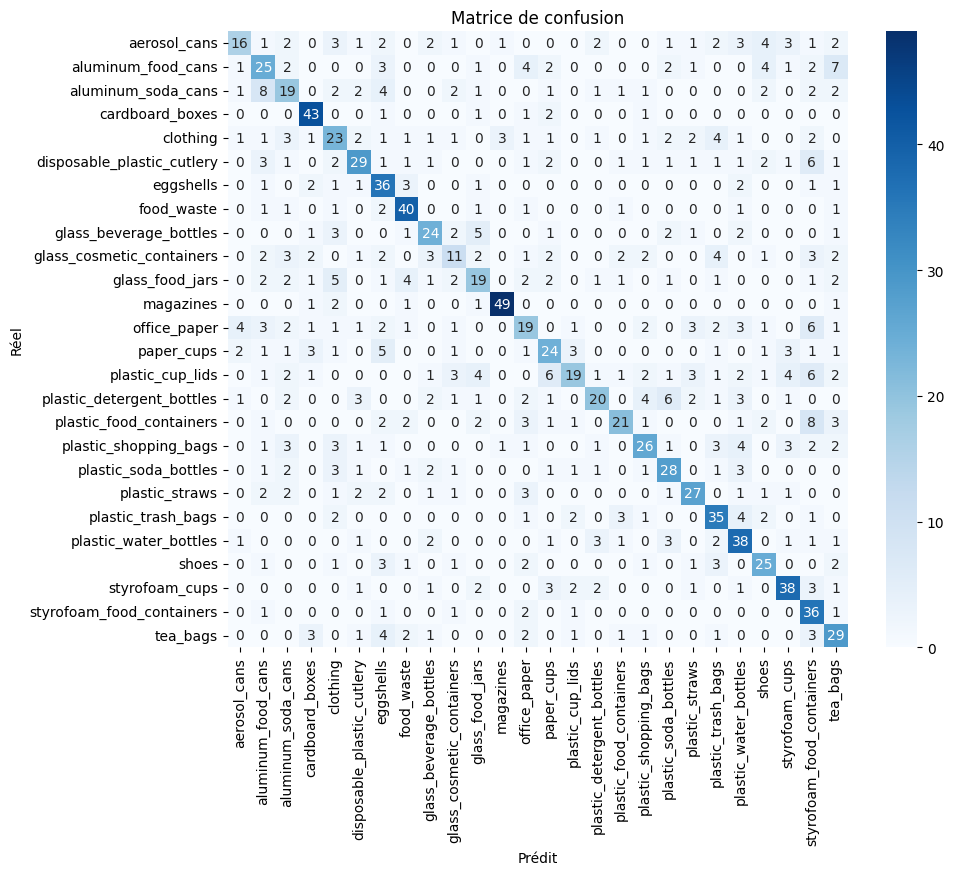

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Récupérer les vraies étiquettes et les prédictions du modèle sur le jeu de validation
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Rapport de classification
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

In [17]:
from tensorflow.keras.preprocessing import image

_, _, class_names = load_datasets(data_dir)

# 2. Charger le modèle
model_path = "waste_classifier.h5"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Le fichier {model_path} est introuvable.")
model = tf.keras.models.load_model(model_path)

# 3. Fonction de prédiction de toutes les classes
def predict_image_all(img_path, model, class_names, img_size=(224, 224)):

    # Charge et redimensionne l'image
    img = image.load_img(img_path, target_size=img_size)
    arr = image.img_to_array(img) / 255.0          # normalisation [0,1]
    arr = np.expand_dims(arr, axis=0)              # ajout de la dimension batch

    # Prédiction complète
    preds = model.predict(arr)[0]                  # vecteur (num_classes,)

    # Retourne la liste des couples (nom, prob)
    return list(zip(class_names, preds))

# 4. Script de test
if __name__ == "__main__":
    # Chemin vers l'image à tester
    img_path = "agaveny.com-le-palmares-des-10-nourritures-gorgees-de-fibres.jpg"
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Le fichier {img_path} est introuvable.")

    # Obtenir toutes les prédictions
    results = predict_image_all(img_path, model, class_names)

    # Trier par probabilité décroissante
    results = sorted(results, key=lambda x: x[1], reverse=True)

    # Afficher
    print(f"Résultats pour l'image : {img_path}\n" + "-"*40)
    for cls, prob in results:
        print(f"{cls:<20} {prob * 100:6.2f}%")

Classes détectées : ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'clothing', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Résultats pour l'image : agaveny.com-le-palmares-des-10-nourritures-gorgees-de-fibres.jpg
----------------------------------------
plastic_soda_bottles  75.47%
food_waste            23.69%
aluminum_soda_cans     0.66%
tea_bags               0.04%
plastic_shopping_bags   0.03%
paper_cups             0.03%
clothing               0.02%
eggshells              0.02%
styrofoam_cups         0.01%
glass_food_jars        0.